<h1 style="color:yellow;">Sequential Data - Deep Learning</h1>

# Arguments

In [ ]:
version = 'DL'
model_results= []

# Deep Learning

In [11]:
import torch
import torch.nn as nn

## Check for device

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Create DataLoaders (Shared for all DL models)

In [13]:
# Note: All models in this setup use the same input shape (N, 1, F)
train_loader, val_loader = create_dataloaders(X_train_processed, y_train_processed, X_val_processed, y_val_processed, batch_size=128)

## Define models

### LSTM

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

### GRU

In [15]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### CNN

In [16]:

class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        conv_out_length = input_length - 2
        pool_out_length = conv_out_length // 2
        self.fc_input_dim = 64 * pool_out_length
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Initializing and training the models

### Getting input size and number of classes

In [17]:
input_size = X_train_processed.shape[1]
num_classes = len(np.unique(y_train_processed))

### LSTM train and evaluate


--- LSTM Model ---


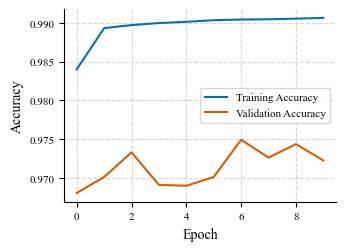

In [18]:
# --- LSTM ---
print("\n--- LSTM Model ---")
lstm_model = LSTMModel(input_size, 64, num_classes)
y_pred_lstm, t_time_lstm, p_time_lstm = train_and_evaluate_pytorch_model(
    lstm_model, train_loader, val_loader, num_epochs=10, device=device, model_name="LSTM"
)

LSTM Evaluation:
Accuracy: 0.97224210
Precision: 0.97236258
Recall: 0.97224210
F1 Score: 0.97224378
Training Time: 375.4808 seconds
Prediction Time: 0.8392 seconds
latency per sample: 0.00000690 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97405665 0.95706907 0.96548814     47821
     HTTPFlood  0.99693033 0.99650350 0.99671687     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99512195 1.00000000 0.99755501      1020
       SYNScan  0.99800200 0.99501992 0.99650873      2008
   SlowrateDoS  0.99294118 0.99445523 0.99369762      7214
TCPConnectScan  0.99796954 0.99847638 0.99822290      1969
      UDPFlood  0.95617291 0.97342156 0.96472014     45789
       UDPScan  0.99632578 0.99815951 0.99724180      1630

      accuracy                      0.97224210    121587
     macro avg  0.98972448 0.99034502 0.99001680    121587
  weighted avg  0.97236258 0.97224210 0.97224378    121587



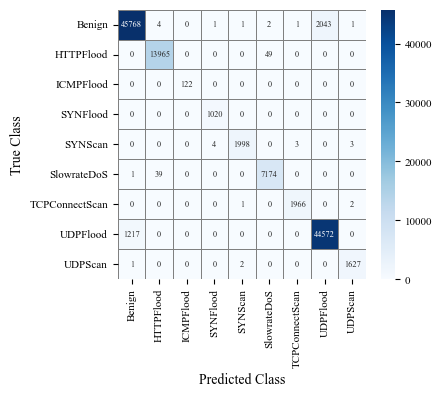

In [19]:
# arguments for evaluation function
results_file_name = 'lstm_results.txt'
cm_title = 'LSTM Confusion Matrix'

print("LSTM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_lstm, t_time_lstm, p_time_lstm, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'lstm', accuracy, precision, recall, f1, t_time_lstm, p_time_lstm)

### GRU train and evaluate


--- GRU Model ---


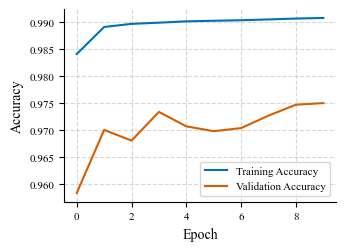

In [20]:
# --- GRU ---
print("\n--- GRU Model ---")
gru_model = GRUModel(input_size, 64, num_classes)
y_pred_gru, t_time_gru, p_time_gru = train_and_evaluate_pytorch_model(
    gru_model, train_loader, val_loader, num_epochs=10, device=device, model_name="GRU"
)

GRU Evaluation:
Accuracy: 0.97503845
Precision: 0.97597016
Recall: 0.97503845
F1 Score: 0.97503495
Training Time: 1105.3533 seconds
Prediction Time: 0.5494 seconds
latency per sample: 0.00000452 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99368842 0.94487777 0.96866860     47821
     HTTPFlood  0.99763898 0.99500500 0.99632025     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800399 0.99601594 0.99700897      2008
   SlowrateDoS  0.98994213 0.99598004 0.99295191      7214
TCPConnectScan  0.99898374 0.99847638 0.99873000      1969
      UDPFlood  0.94543943 0.99377580 0.96900521     45789
       UDPScan  0.99388753 0.99754601 0.99571341      1630

      accuracy                      0.97503845    121587
     macro avg  0.99084269 0.99129744 0.99093315    121587
  weighted avg  0.97597016 0.97503845 0.97503495    121587



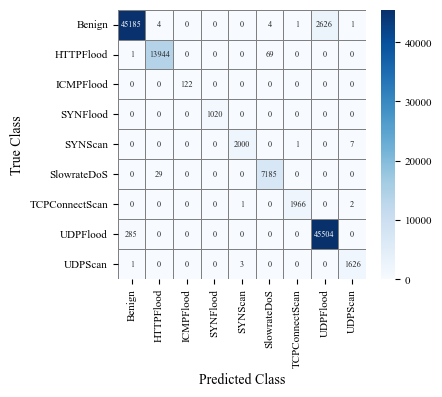

In [21]:
# arguments for evaluation function
results_file_name = 'gru_results.txt'
cm_title = 'GRU Confusion Matrix'

print("GRU Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_gru, t_time_gru, p_time_gru, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'gru', accuracy, precision, recall, f1, t_time_gru, p_time_gru)

### CNN train and evaluate


--- CNN Model ---


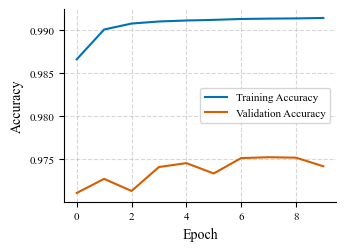

In [22]:
# --- CNN ---
print("\n--- CNN Model ---")
cnn_model = CNNModel(input_size, num_classes)
y_pred_cnn, t_time_cnn, p_time_cnn = train_and_evaluate_pytorch_model(
    cnn_model, train_loader, val_loader, num_epochs=10, device=device, model_name="CNN"
)

Logistic Regression Evaluation:
Accuracy: 0.97417487
Precision: 0.97470235
Recall: 0.97417487
F1 Score: 0.97417469
Training Time: 1739.9374 seconds
Prediction Time: 1.1697 seconds
latency per sample: 0.00000962 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98619102 0.94981284 0.96766015     47821
     HTTPFlood  0.99728436 0.99578992 0.99653658     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99512195 1.00000000 0.99755501      1020
       SYNScan  0.99800399 0.99601594 0.99700897      2008
   SlowrateDoS  0.99185083 0.99542556 0.99363498      7214
TCPConnectScan  0.99847638 0.99847638 0.99847638      1969
      UDPFlood  0.94973289 0.98617572 0.96761129     45789
       UDPScan  0.99693440 0.99754601 0.99724011      1630

      accuracy                      0.97417487    121587
     macro avg  0.99039954 0.99102693 0.99063594    121587
  weighted avg  0.97470235 0.97417487 0.97417469   

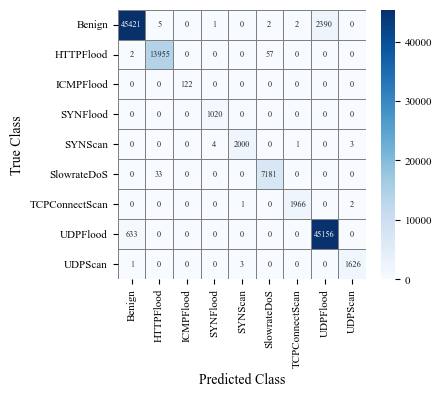

In [23]:
# arguments for evaluation function
results_file_name = 'cnn_results.txt'
cm_title = 'CNN Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_cnn, t_time_cnn, p_time_cnn, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'cnn', accuracy, precision, recall, f1, t_time_cnn, p_time_cnn)

# Bar charts

Saved DL_comparison_accuracy.pdf


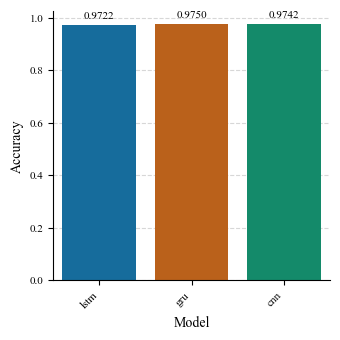

Saved DL_comparison_precision.pdf


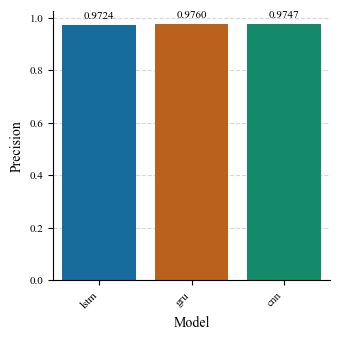

Saved DL_comparison_recall.pdf


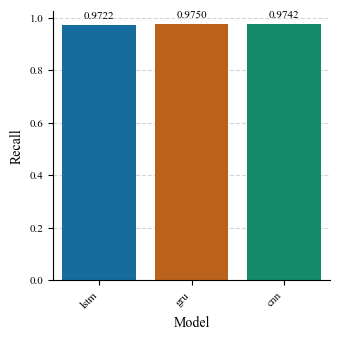

Saved DL_comparison_f1-score.pdf


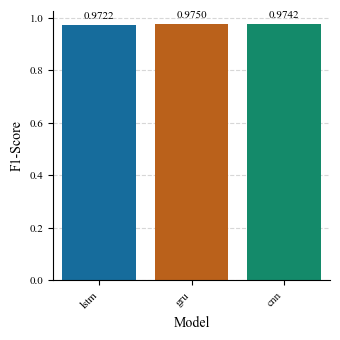

Saved DL_comparison_training_time_s.pdf


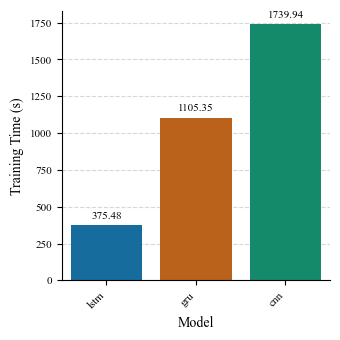

Saved DL_comparison_prediction_time_s.pdf


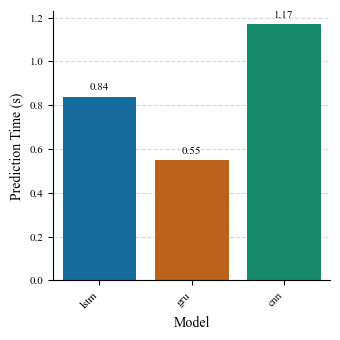

In [24]:
plot_individual_metrics(model_results, evaluation_dir, version)